# Tissuenet Viewer

## Access and inspect the data from the vanvalen-lab 2D immunoflourescence Tissuenet dataset.

**Introduction:**  
Notebook that implements the tissuenet readme instructions for accessing the tissuenet database, augmented to allow for visualisation of image channels and export of data in tif format. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JoeBlackSci/high-plex-whole-cell-segmentation-mp2/tissuenet_viewer.ipynb)

**Tissuenet**:  
Whole-cell segmentation of tissue images with human-level performance using large-scale data annotation and deep learning. doi: https://doi.org/10.1101/2021.03.01.431313 

[LICENSE](https://github.com/vanvalenlab/deepcell-tf/blob/master/LICENSE)

# Installation

In [ ]:
!pip install deepcell

# Initialisation

In [ ]:
import os

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

from deepcell.utils.plot_utils import create_rgb_image
from deepcell.utils.plot_utils import make_outline_overlay
from tifffile import imread, imwrite

# Load Data

Load Test Data. You will need to upload tissuenet to a mounted google drive. Tissuenet is available from: https://datasets.deepcell.org/



In [ ]:
# Path to tissuenet directory
# If using google colab you may need to connect a google-drive. 
npz_dir = '/content/drive/MyDrive/seg/tissuenet_1.0'

# Load numpy save format
test_dict = np.load(os.path.join(npz_dir, 'tissuenet_v1.0_test.npz'))

# Select tissue and Platform

Get image data and metadata from .npz files. Where x is images and y is labels. Then select tissue type and imaging platform if needed.

In [ ]:
test_X, test_y = test_dict['X'], test_dict['y']
tissue_list, platform_list = test_dict['tissue_list'], test_dict['platform_list']

Create list of vlaid tissues and platforms

In [ ]:
valid_tissues = np.unique(tissue_list)
print(valid_tissues)
valid_platforms = np.unique(platform_list)
print(valid_platforms)

['breast' 'gi' 'immune' 'lung' 'pancreas' 'skin']
['codex' 'cycif' 'imc' 'mibi' 'mxif' 'vectra']


Specify the combination of tissues and platforms to inspect. Must be list or 'all'.

In [ ]:
selected_tissue = 'all'
selected_platform = 'all'

Validate selection

In [ ]:
if selected_tissue not in valid_tissues and selected_tissue != 'all':
    raise ValueError('Selected tissue must be either be part of the valid_tissues list, or all')

if selected_platform not in valid_platforms and selected_platform != 'all':
    raise ValueError('Selected platform must be either be part of the valid_platforms list, or all')

# Data Subsetting

Subset the data to include only selected combinations

In [ ]:
if selected_tissue == 'all':
    tissue_idx = np.repeat(True, len(tissue_list))
else:
    tissue_idx = tissue_list == selected_tissue

if selected_platform == 'all':
    platform_idx = np.repeat(True, len(platform_list))
else:
    platform_idx = platform_list == selected_platform

combined_idx = tissue_idx * platform_idx

if sum(combined_idx) == 0:
    raise ValueError("The specified combination of image platform and tissue type does not exist")

selected_X, selected_y = test_X[combined_idx, ...], test_y[combined_idx, ...]

# Image creation

Create rgb images as numpy arrays from numpydata and outlines of image labels.

In [ ]:
rgb_images = create_rgb_image(selected_X, channel_colors=['green', 'blue'])
overlay_data_cell = make_outline_overlay(rgb_data=rgb_images, predictions=selected_y[..., 0:1])
overlay_data_nuc = make_outline_overlay(rgb_data=rgb_images, predictions=selected_y[..., 1:2])

# Visualisation

Randomly chose an image to display

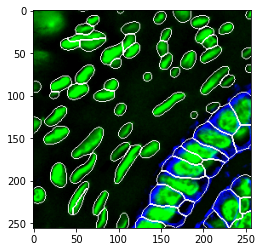

In [ ]:
plot_idx = np.random.randint(0, selected_X.shape[0])
plt.imshow(overlay_data_cell[plot_idx])

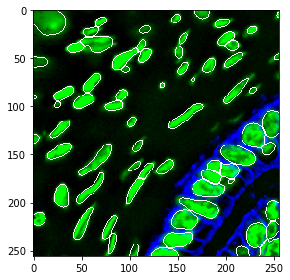

In [ ]:
io.imshow(overlay_data_nuc[plot_idx])

Images are stored in the following 4 dimensional format: (image, row, column, channel).
With channels as 0: nuclear and 1: cell-surface.

Label channels are inverted and stored in the following 4 dimensional format: (image, row, column, channel).
With channels as 1: nuclear and 0: cell-surface.

While it is not intuitive that nuclear and cell surface label index are inverted compared to their associated img index, the channels can be clearly identified with `plotidx=785`.

In [ ]:
selected_X.shape

(1249, 256, 256, 2)

Visualise data

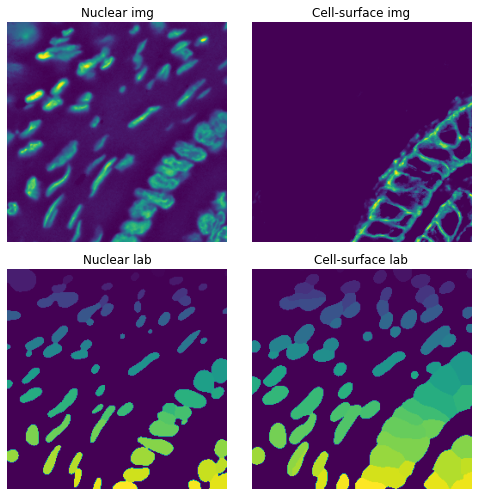

In [ ]:
# Take care to note that img and label channels have inverted indexes
img_nuc, img_suf = selected_X[...,0][plot_idx], selected_X[...,1][plot_idx]
lab_nuc, lab_suf = selected_y[...,1][plot_idx], selected_y[...,0][plot_idx]

plt.figure(figsize=(7,7))

plt.subplot(221)
plt.imshow(img_nuc)
plt.title('Nuclear img')
plt.axis('off')

plt.subplot(222) 
plt.imshow(img_suf)
plt.title('Cell-surface img')
plt.axis('off')

plt.subplot(223)
plt.imshow(lab_nuc)
plt.title('Nuclear lab')
plt.axis('off')

plt.subplot(224) 
plt.imshow(lab_suf)
plt.title('Cell-surface lab')
plt.axis('off')

plt.tight_layout()

plt.show()

# Image saving
Optional code to save images to a directory

In [ ]:
save_images = False     #  save images
save_labels = False     #  save labels
multi_channel = False   #  save as multi-channel tif
nuc = False             #  if not multi, save nucular image
suf = False             #  if not multi, save cell-surface image

dir_path = "path/to/directory/"

if save_images:
    if multi_channel:
        for i in range(selected_X.shape[0]):
                imwrite(dir_path + str(i) + '_com_img.tif', selected_X[i])
    else:
        if nuc:
            for i in range(selected_X.shape[0]):
                imwrite(dir_path + str(i) + '_nuc_img.tif', selected_X[...,0][i])
        if suf:
            for i in range(selected_X.shape[0]):
                imwrite(dir_path + str(i) + '_suf_img.tif', selected_X[...,0][i])
    

if save_labels:
    if multi_channel:
        for i in range(selected_y.shape[0]):
                imwrite(dir_path + str(i) + '_com_lab.tif', selected_y[i])
    else:
        if nuc:
            for i in range(selected_y.shape[0]):
                imwrite(dir_path + str(i) + '_nuc_lab.tif', selected_y[...,0][i])
        if suf:
            for i in range(selected_y.shape[0]):
                imwrite(dir_path + str(i) + '_suf_lab.tif', selected_y[...,0][i])